In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

  
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 
  
import cv2 
import tensorflow as tf 
from tensorflow import keras 
from keras import layers 
from functools import partial 

  
import warnings 
warnings.filterwarnings('ignore') 
AUTO = tf.data.experimental.AUTOTUNE


2023-12-19 04:05:59.549339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 04:05:59.549392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 04:05:59.551272: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 04:05:59.567000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 04:06:01.633216: W tensorflow/compiler/tf2tens

In [2]:

from zipfile import ZipFile 
data_path = 'dog-breed-identification.zip'
  
with ZipFile(data_path, 'r') as zip: 
    zip.extractall() 
    print('The data set has been extracted.') 


The data set has been extracted.


In [3]:

df = pd.read_csv('labels.csv') 
df.head() 


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:


df.shape


(10222, 2)

In [5]:

print('Number of Unique Breeds are :',df['breed'].nunique())


Number of Unique Breeds are : 120


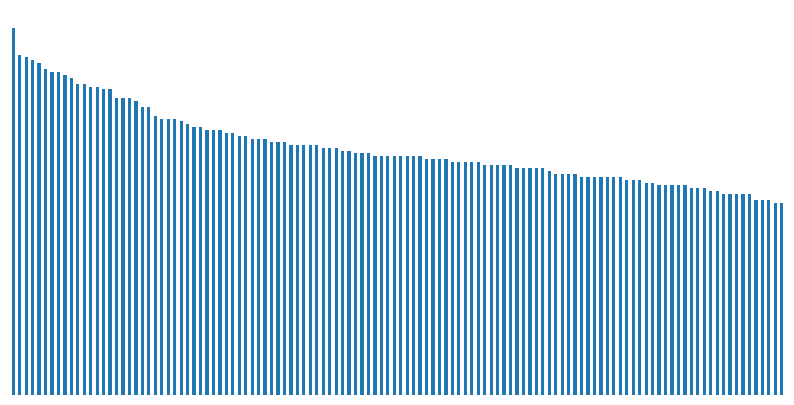

In [6]:

plt.figure(figsize=(10, 5)) 
df['breed'].value_counts().plot.bar() 
plt.axis('off') 
plt.show() 


In [7]:

df['filepath'] = 'train/' + df['id'] + '.jpg'
df.head() 


,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


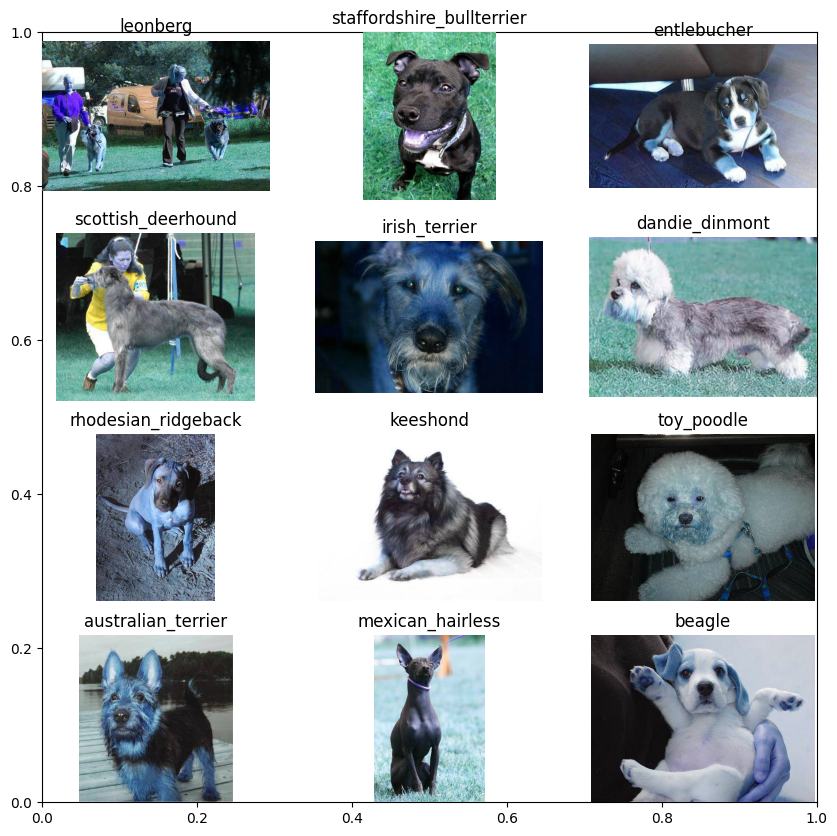

In [8]:

plt.subplots(figsize=(10, 10)) 
for i in range(12): 
    plt.subplot(4, 3, i+1) 
  
    # Selecting a random image 
    # index from the dataframe. 
    k = np.random.randint(0, len(df)) 
    img = cv2.imread(df.loc[k, 'filepath']) 
    plt.imshow(img) 
    plt.title(df.loc[k, 'breed']) 
    plt.axis('off') 
plt.show() 


In [9]:

le = LabelEncoder() 
df['breed'] = le.fit_transform(df['breed']) 
df.head() 


,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


In [10]:
features = df['filepath'] 
target = df['breed'] 
  
X_train, X_val,Y_train, Y_val = train_test_split(features, target, test_size=0.15, random_state=10) 
  
X_train.shape, X_val.shape 

((8688,), (1534,))

In [11]:

import albumentations as A 
  
transforms_train = A.Compose([ 
    A.VerticalFlip(p=0.2), 
    A.HorizontalFlip(p=0.7), 
    A.CoarseDropout(p=0.5), 
    A.RandomGamma(p=0.5), 
    A.RandomBrightnessContrast(p=1) 
]) 


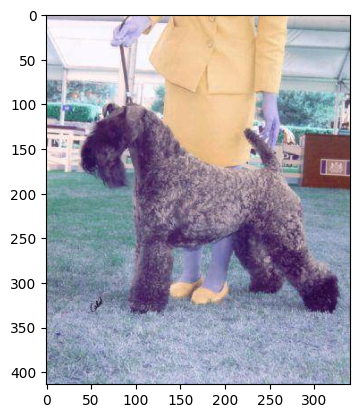

In [12]:

img = cv2.imread('train/0a1f8334a9f583cac009dc033c681e47.jpg') 
plt.imshow(img) 
plt.show()


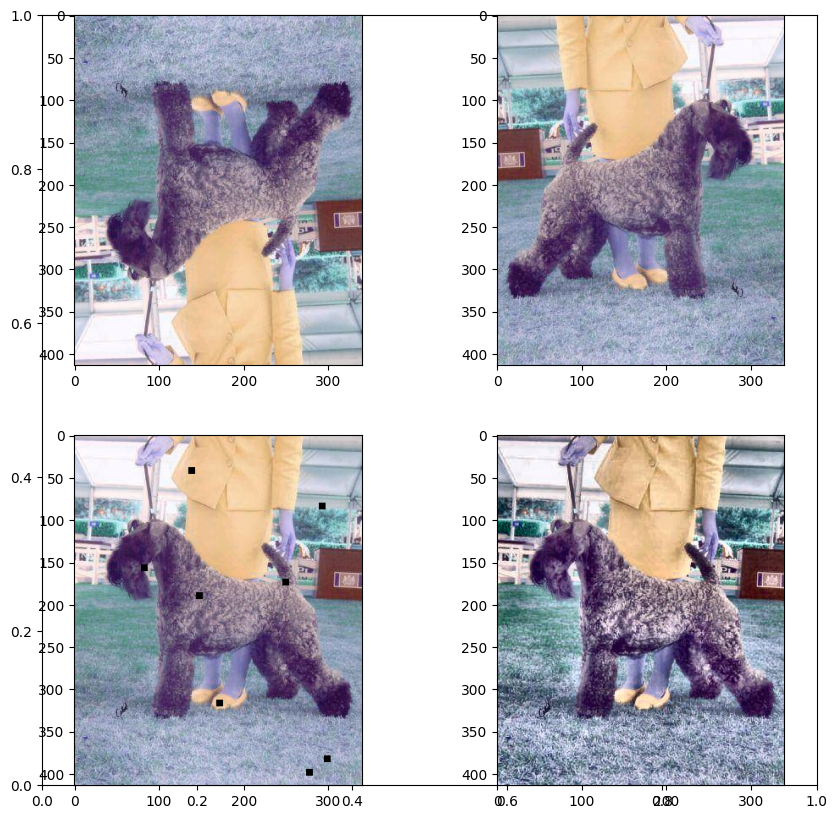

In [13]:

augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1), 
            A.CoarseDropout(p=1), A.CLAHE(p=1)] 
  
plt.subplots(figsize=(10, 10)) 
for i, aug in enumerate(augments): 
    plt.subplot(2, 2, i+1) 
    aug_img = aug(image=img)['image'] 
    plt.imshow(aug_img) 
plt.show() 


In [14]:
def aug_fn(img): 
	aug_data = transforms_train(image=img) 
	aug_img = aug_data['image'] 

	return aug_img 


@tf.function 
def process_data(img, label): 
	aug_img = tf.numpy_function(aug_fn, 
								[img], 
								Tout=tf.float32) 

	return img, label 


def decode_image(filepath, label=None): 

	img = tf.io.read_file(filepath) 
	img = tf.image.decode_jpeg(img) 
	img = tf.image.resize(img, [128, 128]) 
	img = tf.cast(img, tf.float32) / 255.0

	if label == None: 
		return img 

	return img, tf.one_hot(indices=label, 
						depth=120, 
						dtype=tf.float32) 



In [15]:
train_ds = ( 
	tf.data.Dataset 
	.from_tensor_slices((X_train, Y_train)) 
	.map(decode_image, num_parallel_calls=AUTO) 
	.map(partial(process_data), num_parallel_calls=AUTO) 
	.batch(32) 
	.prefetch(AUTO) 
) 

val_ds = ( 
	tf.data.Dataset 
	.from_tensor_slices((X_val, Y_val)) 
	.map(decode_image, num_parallel_calls=AUTO) 
	.batch(32) 
	.prefetch(AUTO) 
) 


In [16]:

from tensorflow.keras.applications.inception_v3 import InceptionV3 
  
pre_trained_model = InceptionV3( 
    input_shape=(128, 128, 3), 
    weights='imagenet', 
    include_top=False
) 



In [17]:


len(pre_trained_model.layers)


311

In [18]:

for layer in pre_trained_model.layers: 
  layer.trainable = False
  
last_layer = pre_trained_model.get_layer('mixed7') 
print('last layer output shape: ', last_layer.output_shape) 
last_output = last_layer.output


last layer output shape:  (None, 6, 6, 768)


In [19]:
 #Model Architecture 
x = layers.Flatten()(last_output) 
x = layers.Dense(256, activation='relu')(x) 
x = layers.BatchNormalization()(x) 
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.3)(x) 
x = layers.BatchNormalization()(x) 
output = layers.Dense(120, activation='softmax')(x) 
  
model = keras.Model(pre_trained_model.input, output) 
  
# Model Compilation 
model.compile( 
    optimizer='adam', 
    loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
    metrics=['AUC'] 
) 

In [20]:
history = model.fit(train_ds,validation_data=val_ds, epochs=50, verbose=1) 


Epoch 1/50
272/272 [==============================] - 238s 842ms/step - loss: 3.7247 - auc: 0.8216 - val_loss: 2.6216 - val_auc: 0.9328
Epoch 2/50
272/272 [==============================] - 220s 810ms/step - loss: 2.0122 - auc: 0.9691 - val_loss: 2.3851 - val_auc: 0.9432
Epoch 3/50
272/272 [==============================] - 242s 889ms/step - loss: 1.0299 - auc: 0.9942 - val_loss: 2.3989 - val_auc: 0.9255
Epoch 4/50
272/272 [==============================] - 190s 696ms/step - loss: 0.4002 - auc: 0.9993 - val_loss: 2.4906 - val_auc: 0.9174
Epoch 5/50
272/272 [==============================] - 167s 616ms/step - loss: 0.1661 - auc: 0.9998 - val_loss: 2.5054 - val_auc: 0.9151
Epoch 6/50
272/272 [==============================] - 147s 540ms/step - loss: 0.0882 - auc: 0.9999 - val_loss: 2.5949 - val_auc: 0.9044
Epoch 7/50
272/272 [==============================] - 143s 526ms/step - loss: 0.0546 - auc: 1.0000 - val_loss: 2.6102 - val_auc: 0.8997
Epoch 8/50
  1/272 [............................

KeyboardInterrupt: 